### Fourier Transforms For Detecting Seasonality and Feature Engineering

This is the notebook that provides code for this article: [link](https://nathaniel-lanier.medium.com/fourier-transforms-for-detecting-seasonality-and-feature-engineering-5a91fbfe6e7c)  
Some of the code here has been adapted from [Steve Brunton's Youtube Channel](https://www.youtube.com/watch?v=s2K1JfNR7Sc)  
The AEP Energy Usage dataset can be found [here](https://www.kaggle.com/robikscube/hourly-energy-consumption)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
df = pd.read_csv('AEP_hourly.csv')
df = df.sort_values(['Datetime'])

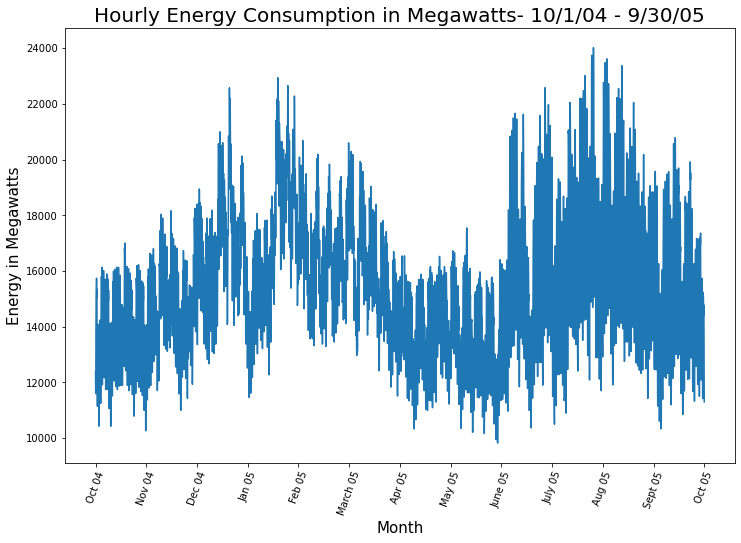

In [40]:
# Plot for 1 year of energy usage data
plt.figure(figsize=(12,8))
plt.plot(df['Datetime'][0:8760], df['AEP_MW'][0:8760])
locs, labels = plt.xticks()
plt.xticks([i*730 for i in range(13)],['Oct 04', 'Nov 04', 'Dec 04', 'Jan 05', 'Feb 05', 'March 05', 
                    'Apr 05', 'May 05', 'June 05', 'July 05', 'Aug 05', 'Sept 05', 'Oct 05'], rotation=70)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Energy in Megawatts', fontsize= 15)
plt.title('Hourly Energy Consumption in Megawatts- 10/1/04 - 9/30/05', fontsize=20)
plt.savefig("figs/AEP_1year.png", bbox_inches='tight', dpi=600)

In [5]:
# create dfs for week1 and week2
df_2weeks = df[0:336]
df_2weeks = df_2weeks.assign(normalized = df_2weeks.AEP_MW - np.mean(df_2weeks.AEP_MW))
df_week1 = df_2weeks[0:168]
df_week2 = df_2weeks[168:336]

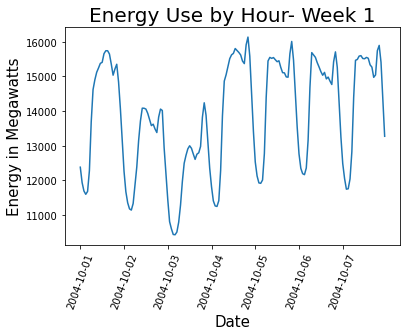

In [41]:
# plot of energy usage for first week of data
plt.plot(df[0:168].Datetime, df[0:168].AEP_MW)
locs, labels = plt.xticks()
plt.xticks([0,24,48,72,96,120,144], ['2004-10-01', '2004-10-02', '2004-10-03', '2004-10-04', '2004-10-05', '2004-10-06', '2004-10-07'],rotation=70)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy in Megawatts', fontsize= 15)
plt.title('Energy Use by Hour- Week 1', fontsize=20) 
plt.savefig("figs/1week.png", bbox_inches='tight', dpi=600)

In [11]:
f = df_week1['normalized']
t = np.arange(0,len(f),1)

Formula for the Discrete Fourier Transform and Inverse transform:  
$$
\hat{f}_{k}=\sum_{n=0}^{N-1} f_{n} e^{-i 2 \pi n k / N}
$$
$$
f_{k}=\frac{1}{N}\left(\sum_{n=0}^{N-1} \hat{f}_{n} e^{i 2 \pi n k / N}\right)
$$
Below we are using the Fast Fourier Transform which is essentially a computationally efficient version of the above formula

In [7]:
## Compute the Fast Fourier Transform (FFT) and filter out all elements of PSD < 1e7

n = len(f)
fhat = np.fft.fft(f,n)                     
PSD = fhat * np.conj(fhat) / n             
freq = np.fft.fftfreq(n)           
L = np.arange(1,np.floor(n/2),dtype='int')
indices = PSD > 1e7  
fhat = indices * fhat     
ffilt = np.fft.ifft(fhat) 

In [9]:
# select indices of important frequencies
wave_indices = [i for i in range(len(fhat)) if fhat[i] != 0]

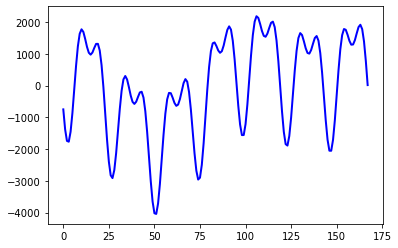

In [29]:
# plot filtered data
df_wave = pd.DataFrame()
for i in wave_indices:
    index = ([False]*168)
    index[i] = True
    w = np.fft.ifft(fhat * index)
    df_wave[i] = w.real
df_wave['sum'] = 0   
for i in wave_indices:
    df_wave['sum'] += df_wave[i]
plt.plot(t,df_wave['sum'],color='b',LineWidth=2,label='Filtered')

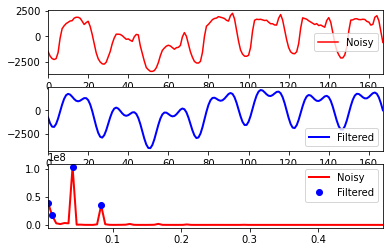

In [28]:
## Plots for noisy data clean data and noisy/filtered in freq domain
PSDclean_ind = [i for i in range(len(PSDclean)) if PSDclean[i] != 0]
fig,axs = plt.subplots(3,1)

plt.sca(axs[0])
plt.plot(t,f,color='r',LineWidth=1.5,label='Noisy')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(t,ffilt.real,color='b',LineWidth=2,label='Filtered')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L].real,color='r',LineWidth=2,label='Noisy')
plt.plot(freq[PSDclean_ind],PSDclean[PSDclean_ind].real,'ro',color='b',LineWidth=1.5,label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()
plt.show()

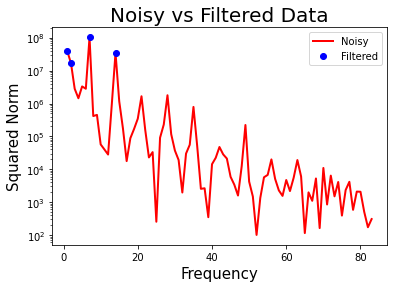

In [42]:
# plot noisey and filtered data in freq domain for 1 week
def normalize_week_graph(week, mean):
    i, j = 168*(week-1), 168*week
    df_temp = df[i: j]
    mean = np.mean(df_temp['AEP_MW'])
    df_temp = df_temp.assign(normalized = df_temp.AEP_MW - mean)
    return df_temp
def fourier_df_graph(df_temp):
    f = df_temp['normalized']
    t = np.arange(0,len(f),1)
    n = len(f)
    fhat = np.fft.fft(f,n)                     
    sq_norm = fhat * np.conj(fhat) / n             
    freq = np.fft.fftfreq(n)
    L = np.arange(1,np.floor(n/2),dtype='int') 
    indices = sq_norm >  1e7  
    sq_norm_clean = sq_norm * indices  
    fhat = indices * fhat     
    wave_indices = [i for i in range(len(fhat)) if fhat[i] != 0]
    df_wave = pd.DataFrame()
    for i in wave_indices:
        index = ([False]*168)
        index[i] = True
        w = np.fft.ifft(fhat * index)
        df_wave[i] = w.real
    df_wave['sum'] = 0   
    for i in wave_indices:
        df_wave['sum'] += df_wave[i]
    plt.plot(t[L],sq_norm[L].real,color='r',LineWidth=2,label='Noisy')
    plt.plot(t[L],sq_norm_clean[L].real,'ro',color='b',LineWidth=1.5,label='Filtered')
    locs, labels = plt.xticks()
    plt.xlabel('Frequency', fontsize=15)
    plt.ylabel('Squared Norm', fontsize= 15)
    plt.title('Noisy vs Filtered Data', fontsize=20) 
    plt.yscale('log')
    plt.legend()
    plt.savefig("figs/nvflog.png", bbox_inches='tight', dpi=600)
mean = None
fourier_df_graph(normalize_week_graph(1, mean))

In [15]:
#adapted from Steve Brunton's 
#fantastic YouTube channel: 
#https://www.youtube.com/watch?v=s2K1JfNR7Sc
def normalize_week(week, mean):
    """returns a df with noise filtered and a series of the normalized data"""
    i, j = 168*(week-1), 168*week
    df_temp = df[i: j]
    df_temp = df_temp.assign(normalized = 
                    df_temp.AEP_MW - mean)
    return df_temp
def fourier_df(df_temp):
    """returns df with noise filtered out of energy usage data"""
    f = df_temp['normalized']
    t = np.arange(0,len(f),1)
    n = len(f)
    fhat = np.fft.fft(f,n)                     
    sq_norm = fhat * np.conj(fhat) / n             
    freq = np.fft.fftfreq(n)
    L = np.arange(1,np.floor(n/2),dtype='int') 
    indices = sq_norm >  1e7  
    sq_norm_clean = sq_norm * indices  
    fhat = indices * fhat     
    wave_indices = [i for i in range(len(fhat)) 
                    if fhat[i] != 0]
    df_wave = pd.DataFrame()
    for i in wave_indices:
        index = ([False]*168)
        index[i] = True
        w = np.fft.ifft(fhat * index)
        df_wave[i] = w.real
    df_wave['sum'] = 0   
    for i in wave_indices:
        df_wave['sum'] += df_wave[i]
    return df_wave, df_temp['normalized']

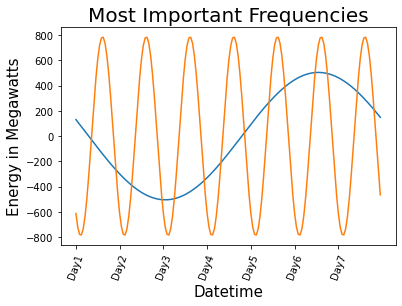

In [43]:
# plots the two most important frequencies
mean = np.mean(df[0:168].AEP_MW)
week1 = normalize_week(2, mean)
X, y = fourier_df(week1)
plt.plot([i for i in range(168)],X[1])
plt.plot([i for i in range(168)],X[7])
plt.xticks([0,24,48,72,96,120,144],['Day1','Day2','Day3','Day4','Day5','Day6','Day7'],rotation=70)
plt.xlabel('Datetime', fontsize=15)
plt.ylabel('Energy in Megawatts', fontsize= 15)
plt.title('Most Important Frequencies', fontsize=20) 
plt
plt.savefig("figs/impfreq.png", bbox_inches='tight', dpi=600)

In [17]:
# train linear regression model on transformed data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

mean = np.mean(df[0:168].AEP_MW)
week1 = normalize_week(1, mean)
X, y = fourier_df(week1)

linreg = LinearRegression(fit_intercept=True)
linreg.fit(X[['sum']], y)

train_RMSE = mean_squared_error(y,linreg.predict(X[['sum']]),squared = False)
print('train RMSE:',(train_RMSE))
baseline_RMSE = mean_squared_error(y,np.zeros(168),squared = False)
baseline_RMSE

train RMSE: 486.4469324996386


1598.0629201953673

In [18]:
# iterate through a year of data and compute average rmse for year based on model trained on transformed data
def test_model(X, y):
    baseline_RMSE = mean_squared_error(y,
            [0 for i in range(len(y))],squared = False)
    val_RMSE = mean_squared_error(y,
            linreg.predict(X[['sum']]),squared = False)
    return baseline_RMSE, val_RMSE
def test_year():
    base_list = []
    val_list = []
    for n in range(2,53):
        mean = np.mean(df[(n-1)*168:n*168].AEP_MW)
        week_n = normalize_week(n,mean)
        X, y = fourier_df(week_n)
        base, val = test_model(X,y)
        base_list.append(base)
        val_list.append(val)
        mean = np.mean(week_n.AEP_MW)
    print(f"average baseline score: {np.mean(base_list)}") 
    print(f"average val score: {np.mean(val_list)}")
test_year()

average baseline score: 1966.1612131526176
average val score: 536.008992128845


In [19]:
# compute average baseline and rmse for model generated from week i and used to predict week i+1
def test_model(X, y):
    baseline_RMSE = mean_squared_error(y,[0 for i in range(len(y))],squared = False)
    val_RMSE = mean_squared_error(y,linreg.predict(X[['sum']]),squared = False)
    return baseline_RMSE, val_RMSE
def test_year():
    base_list = []
    val_list = []
    mean = np.mean(df[0:168].AEP_MW)
    week_n_m_1 = normalize_week(1,mean)
    for n in range(2,53):
        week_n = normalize_week(n,mean)
        X, y = fourier_df(week_n_m_1)
        base, val = test_model(X,week_n['normalized'])
        base_list.append(base)
        val_list.append(val)
        mean = np.mean(week_n.AEP_MW)
    print(f"average base score: {np.mean(base_list)}") 
    
    print(f"average val score: {np.mean(val_list)}")
test_year()

average base score: 2208.1262311622477
average val score: 1648.889866599438


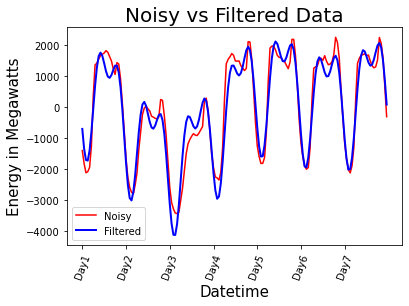

In [39]:
# graph of filtered data superimposed on noiisey data
plt.plot(t,week1['normalized'],color='r',LineWidth=1.5,label='Noisy')
plt.legend()
plt.plot(t,X['sum'],color='b',LineWidth=2,label='Filtered')
locs, labels = plt.xticks()
plt.xticks([0,24,48,72,96,120,144],['Day1','Day2','Day3','Day4','Day5','Day6','Day7'],rotation=70)
plt.xlabel('Datetime', fontsize=15)
plt.ylabel('Energy in Megawatts', fontsize= 15)
plt.title('Noisy vs Filtered Data', fontsize=20) 
plt.savefig("figs/nvf2.png", bbox_inches='tight', dpi=600)
plt.legend()

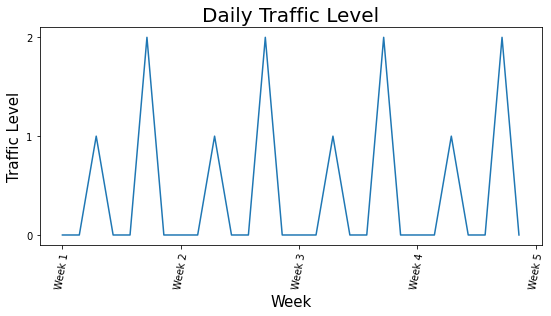

In [33]:
# plot for toy example in medium article
noise_level = []
days = []
d = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in [1,2,3,4]:
    for day in d:
        days.append(f"week-{i} {day}")
for i in range(28):
    if i%7 == 5:
        noise_level.append(2)
    elif i%7 == 2:
        noise_level.append(1)
    else:
        noise_level.append(0)

plt.figure(figsize=(9,4))
plt.plot(days, noise_level)
locs, labels = plt.xticks()
plt.xticks([0,7,14,21,28],['Week 1', 'Week 2', 'Week 3', 'Week 4','Week 5'], rotation=80)
plt.yticks([0,1,2])
plt.xlabel('Week', fontsize=15)
plt.ylabel('Traffic Level', fontsize= 15)
plt.title('Daily Traffic Level', fontsize=20) 

In [36]:
from platform import python_version

print(python_version())

3.8.3
